# MRSA Clearance
## Figures and Tables for the Manuscript: 

## *"Bayesian survival analysis for the impact of antibiotic resistance on the efficiency MRSA decolonization"*


### Directories

`scripts`: Relevant scripts for preprocessing, data visualization etc.

`data`: Data files

`results`: Figures and Tables as in the articles

`saved_models`: Pretrained models 

### Using a Computing Cluster

It is recommended to fit the survival models (especially with random effects) on a computing cluster & the fitted models should be saved in the `saved_models` directory for visualization in this notebook. Instructions for using a computing cluster are at the end of the notebook. This notebook details an example of generating a simpler model (no random effects) that can be run locally.

In [1]:
# Set local root directory (if different from working directory)
root <- ""

# 1. Data Preprocessing


## 1.1 General Preprocessing Steps
- Combine available data sets: BLAST (chlorhexidine) and Mykrobe predictor (other antibiotics) results
- Exclude hosts that did not complete all visits
- Remove isolates marked as MSSA
- Remove contaminated isolates
- Remove duplicates (same site, same visit, same host)

See `scripts/mdata_preprocessing.R` for details.

In [2]:
# Specify data files within the mdata_preprocessing.R script

source(paste(root, "scripts/mdata_preprocessing.R", sep = ""))
mykrobe_data <- preprocess_mykrobe_data(output = T) # General preprocessing steps, such as cleanup of the data, 
# data type conversions etc.

[1] "Isolates in mykrobe_data (unfiltered): 3998"
[1] "Hosts in mykrobe_data (unfiltered): 896"
[1] "Adding Chlorhexidine from BLAST..."
[1] "Testing Mykrobe and BLAST merge"
[1] "PASSED: Same length."
[1] "nrow after adding BLAST: 3998"
[1] "Adding visit data..."
[1] "Removing hosts that did not complete all visits, n_hosts removed = 17"
[1] "Removing hosts that did not complete all visits, n_isolates removed =  97"
[1] "Testing Removed hosts that did not complete all visits"
[1] "PASSED: Same length."
[1] "nrow after removing hosts that did not attend all visits: 3901"
[1] "Removing contaminated isolates.."
[1] "Testing "
[1] "PASSED: Same length."
[1] "Removed contaminated isolates, n_isolates removed: 11"
[1] "Removed contaminated isolates, n_hosts removed: 1"
[1] "Removing MSSA cases..."
[1] "Testing MSSA isolates"
[1] "PASSED: Same length."
[1] "Removed MSSA cases, n_isolates removed: 43"
[1] "Removed MSSA cases, n_hosts removed: 7"
[1] "Removing duplicates: same host, same visit

## 1.2 Strain Assignment

Strains are assigned using *BaeMBac*, separately for ST5 and ST8. For this, we need a data frame with the SNP distance and time (in generations) between two consecutive MRSA isolates. Here, we create two data frames, one for ST5 isolates and one for ST8 isolates. It is recommended to save `dfst5` and `dfst8` data frames as .RData objects to avoid recreating them during each run.

These data frames are used as input for [*BaeMBac*](https://github.com/mjarvenpaa/bacterial-colonization-model) software, which assigns same-strain/different-strain probabilities for each isolate pair. *BaeMBac* should be run on a computing cluster. Please see `strains` folder for helper scripts.

In [3]:
source(paste(root, "scripts/get_consecutive_dist.R", sep = "")) # functions for creating dfst8 and dfst5

st5_dist_file <- paste(root, "data/03_matrix_ST5_all_sites.tsv", sep = "")
st8_dist_file <- paste(root, "data/03_matrix_ST8_all_sites.tsv", sep = "")

dfst5 <- filter_dfst(get_most_recent_distances_df(mykrobe_data, st=5, st_dist_file=st5_dist_file))
dfst8 <- filter_dfst(get_most_recent_distances_df(mykrobe_data, st=8, st_dist_file=st8_dist_file))

dim(dfst5)
dim(dfst8)

saveRDS(dfst5, file = "data/dfst5.RData")
saveRDS(dfst8, file = "data/dfst8.RData")

[1] 2972   11

[1] 4645   11

## 1.3 Survival Data Preprocessing

For the purposes of survival analysis, the data needs to be resturctured. Survival data consists of an event indicator (clearance of MRSA colonization), time-to-event and covariates (antimicrobial resistance profile). Check the manuscript for details.

If there was a missing resistance from a strain, it will be replaced by the most common status of the antibiotic of interest. Otherwise the missing resistance will be marked as NA.


In [4]:
source("scripts/surv_preprocessing_strains.R")

saveRDS(data, paste(root, "data/surv_data/data.RData", sep = ""))
saveRDS(data_sites, paste(root, "data/surv_data/data_sites.RData", sep = ""))

[1] "Adding Chlorhexidine from BLAST..."
[1] "Testing Mykrobe and BLAST merge"
[1] "PASSED: Same length."
[1] "Adding visit data..."
[1] "Testing Removed hosts that did not complete all visits"
[1] "PASSED: Same length."
[1] "Removing contaminated isolates.."
[1] "Testing "
[1] "PASSED: Same length."
[1] "Removing MSSA cases..."
[1] "Testing MSSA isolates"
[1] "PASSED: Same length."
[1] "Removing duplicates: same host, same visit, same site."
[1] "Constructing clearance matrix..."
[1] "Required igraph"


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




[1] "# of different substrains: 859"
[1] "Adding resistance... Number of rows with missing resistances: 417"
[1] "DONE. Number of rows with missing resistance after adding: 112"
[1] "Constructing survival data..."
[1] "mdata before surv_data: 3305"
[1] "mdata before surv_data n_hosts: 800"
[1] "mdata, NA hosts removed: 3305"
[1] "mdata, overall strains: 1151"
[1] "surv_data before omitting missed swabs, n obs: 1908"
[1] "surv_data before omitting missed swabs, n hosts: 775"
[1] "Missing values: 28"
[1] "Removing missing swabs, n = 28"
[1] "surv_data after omitting missed swabs, n obs: 1880"
[1] "surv_data after omitting missed swabs, n hosts: 767"
[1] "Removing V3-V4 observations (t0 == V3), n = 373"
[1] "surv_data after omitting V4 1507"
[1] "surv_data after omitting V4, n hosts: 738"
[1] "ARM"                 "ID"                  "group"              
[4] "Visit.."             "CHG.Bathing"         "CHG.Oral.Rinse"     
[7] "Mupirocin.Adherence"
[1] "Removed non-adherent cases, D ar

In [5]:
head(data) # restructured data

,Visit..,host_id,strain,y,ARM,delta_t,ST,Ciprofloxacin,Clindamycin,Erythromycin,Gentamicin,Mupirocin,Rifampicin,Tetracycline,Trimethoprim,Chlorhexidine,t0,CHG.Bathing,CHG.Oral.Rinse,Mupirocin.Adherence
,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,V1,1003,135,0,1,1.200000,5,1,1,1,0,0,0,0,0,0,1.200000,1,1,1
3,V1,1008,1,3,1,1.000000,5,1,1,1,0,0,1,0,0,1,0.010000,1,1,1
6,V1,1018,1097,3,1,1.000000,8,1,0,1,0,0,0,0,0,0,0.010000,1,1,1
13,V1,1029,360,0,1,1.633333,8,1,0,1,0,0,0,0,0,0,1.633333,1,1,1
16,V1,1048,1123,3,1,1.000000,8,1,0,0,0,0,0,0,0,0,0.010000,1,1,1
21,V1,1058,362,0,1,1.000000,8,1,0,1,1,1,0,0,0,0,1.000000,1,1,1


In [6]:
head(mykrobe_data) # original data for comparison

,Isolate,Accession..,ARM,ID,Cx.Date,Visit..,Cx.Site,ST,group,run,⋯,mismatches_qacA,indels_qacA,qacC_gene,length_qacC,mismatches_qacC,indels_qacC,qacR_gene,length_qacR,mismatches_qacR,indels_qacR
,<chr>,<chr>,<chr>,<int>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,5005_02,H72199,E,2021,11-03-17,R0,skin,5,HN,run8,⋯,-,-,-,-,-,-,-,-,-,-
5,5005_08,W18433,E,1050,11-03-23,R0,throat,-,NN,run8,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,5005_10,H75205,E,1026,11-03-24,V1,wound,8,NN,run8,⋯,-,-,-,-,-,-,-,-,-,-
7,5005_11,H75214,E,1028,11-03-24,V1,skin,8,NN,run8,⋯,-,-,-,-,-,-,-,-,-,-
8,5005_12,M70593,E,1055,11-03-28,R0,skin,8,NN,run8,⋯,-,-,-,-,-,-,-,-,-,-
9,5005_14,T34709,D,1057,11-03-29,R0,throat,8,NN,run8,⋯,-,-,-,-,-,-,-,-,-,-


# 2. Exploratory Analysis

In [7]:
## Load the data ##

is_mod1 <- F # model 1: each antibiotic in a separate model, by default False. Do not change.
data <- readRDS(paste(root, "data/surv_data/data.RData", sep = "")) # strain-specific data
data_sites <- readRDS(paste(root, "data/surv_data/data_sites.RData", sep = "")) # site-specific data
treatments <- readRDS(paste(root, "data/surv_data/treatments.RData", sep = "")) # character vector of antimicrobial names

## Set directories ##

# Directory where the models are saved
savedir <- "saved_models/"

# Directories for saving the figures and result tables

fig_savedir <- paste(root, "results/figures/", sep = "")
table_savedir <- paste(root, "results/tables/", sep = "")

## Other ##
source(paste(root, "scripts/utilities.R", sep = "")) # utility functions
source("scripts/article_vis.R") # plotting functions
theme_set(theme_cowplot(font_family = "Times", font_size=12)) # font size and type


[1] "Required ggplot2"


Loading required package: ggplot2



[1] "Required gridExtra"


Loading required package: gridExtra



[1] "Required cowplot"


Loading required package: cowplot



[1] "Required bayesplot"


Loading required package: bayesplot

This is bayesplot version 1.9.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



[1] "Required reshape2"


Loading required package: reshape2



[1] "Required rstanarm"


Loading required package: rstanarm

Loading required package: Rcpp

This is rstanarm version 2.21.2

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



[1] "Required igraph"


## 2.1 Fig 1. Network visualization of MRSA colonization

This visualization shows, by body site and by visit, how the MRSA colonization proceeds in a host. The first example host has a persistent MRSA colonization of the same strain, while the second example host has four different colonizing MRSA strains. Note that many hosts had only one MRSA positive isolate sampled from them, unlike these example cases.

[1] "Required igraph"
[1] "# of different substrains: 859"
[1] "Required igraph"
[1] "Required igraph"


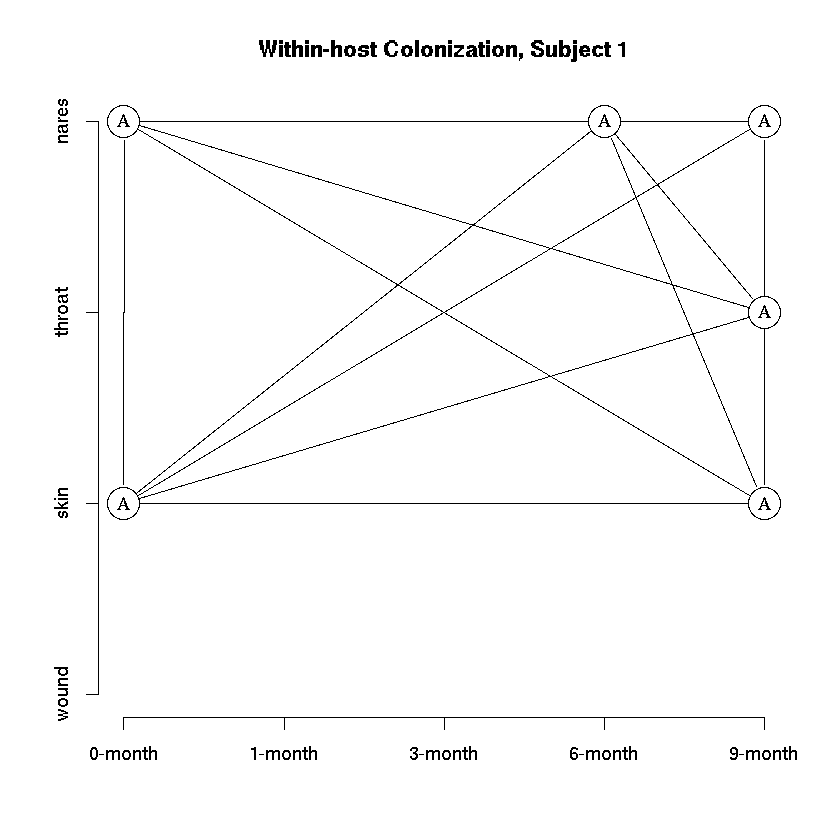

[1] 0 1 2 3

PNG 
  2

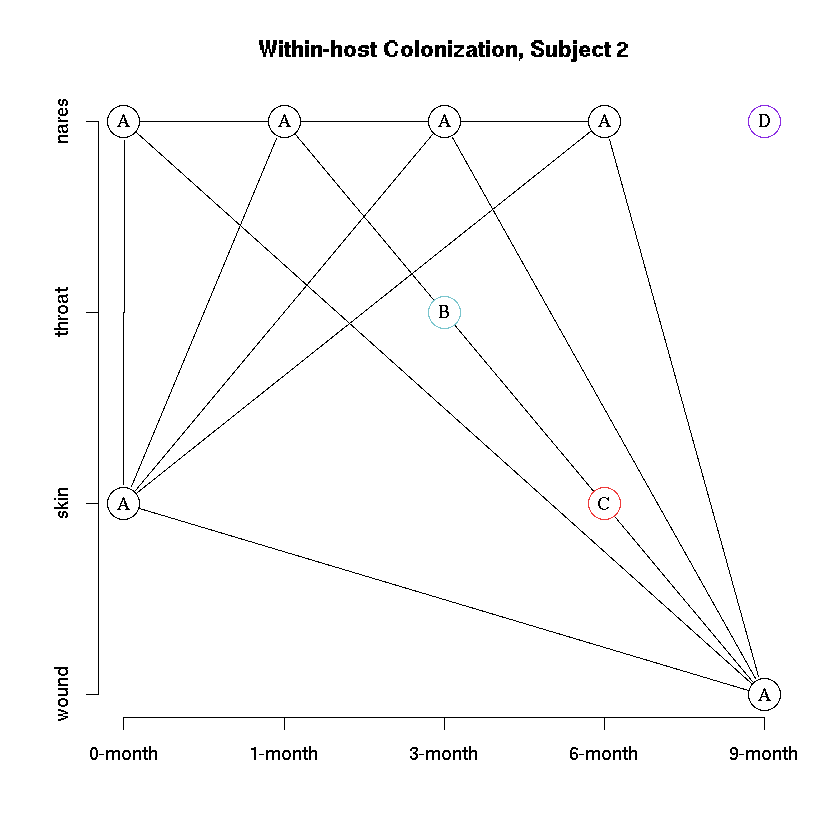

In [8]:
source("scripts/strain_functions.R")

dfst5 <- readRDS("data/dfst5.RData")
dfst8 <- readRDS("data/dfst8.RData")

dfst <- add_threshold_strains(rbind(dfst5, dfst8))

host <- 1008
t <- vis_mrc_df_6(dfst[which(dfst$host == host),], title_addon = ", Subject 1") # A host with only one strain

host <- 1059 #2213
t <- vis_mrc_df_6(dfst[which(dfst$host == host),], title_addon = ", Subject 2") # A host with multiple strains


pdf(paste(fig_savedir, "Fig1A.pdf", sep = ""), height = 4, width = 4)
t
dev.off()

## 2.2 Fig 2. Resistance and clearance probabilities from survival data

In [9]:
#get_resclear(data, "Chlorhexidine")
rc_mup_d <- get_resclear(data[which(data$ARM == 1),], "Mupirocin")
#get_resclear_barplot(data, "Chlorhexidine")
rc_mup_d
# proportion cleared and resistant out of all resistant obs:
print("Resistant and cleared:")
rc_mup_d[,"rc"]/rc_mup_d[,"res"]
# proportion of cleared and non-resistant out of all non-resistant obs:
print("Non-resistant and cleared:")
rc_mup_d[,"nrc"]/rc_mup_d[,"non_res"]



rc,nrc,res,non_res
10,156,31,232


[1] "Resistant and cleared:"


rc 
0.3225806

[1] "Non-resistant and cleared:"


nrc 
0.6724138

Using ARM as id variables

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Using ARM as id variables



PNG 
  2

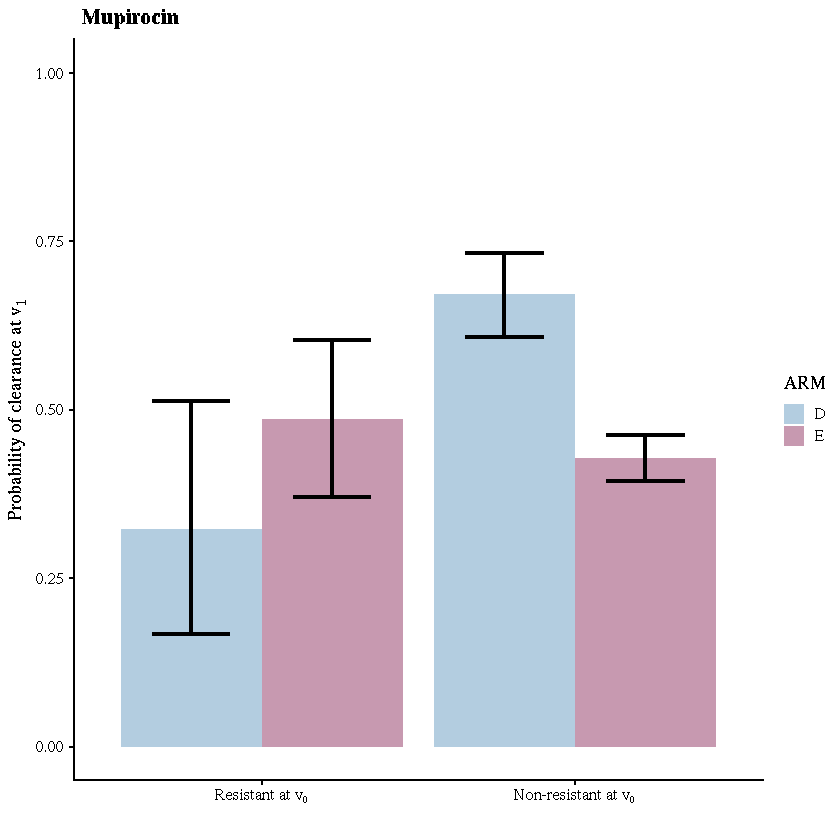

In [10]:
# Generate & save Fig 2
get_resclear_barplot(data, "Mupirocin")

pdf(paste(fig_savedir, "Fig2.pdf", sep = ""), height = 4, width = 4)
get_resclear_barplot(data, "Mupirocin")
dev.off()

## 2.3 Table 1. Number of strains and hosts

For survival data!

In [11]:
# Take a look at the number of multiply colonized hosts:

get_multistrain_table <- function(data){
    #' Get the number of hosts with 1...n strains
    #'
    #' Also calculate the percentage of hosts (hosts/all hosts)
    #'
    #' @param data Survival data frame.
    
    host_strain_unique <- unique(data[c("host_id", "strain")])
    tab <- table(host_strain_unique$host_id)
    
    multistrain_table <- as.data.frame(table(tab))

    # Visit.. here is the second visit of the interval. Why 2213 seems to have only 4 strains, not 5: the fifth strain is
    # present only at V3 and V4, and will therefore be excluded.

    colnames(multistrain_table) <- c("n_strains", "n_hosts")
    
    multistrain_table$n_hosts <- paste(multistrain_table$n_hosts, multistrain_table$percent, sep = " ")
    
    colnames(multistrain_table) <- c("n Strains", "n Hosts (%)")
    
    return(multistrain_table)

}

# Divide to education and decolonization?
multistrain_tab_d <- get_multistrain_table(data[which(data$ARM == 1),])
multistrain_tab_e <- get_multistrain_table(data[which(data$ARM == 0),])

multistrain_tab_arm <- data.frame("n Strains" = multistrain_tab_d[,c("n Strains")],
                                  "Decolonization n Hosts (%)" = multistrain_tab_d[,2],
                                 "Education n Hosts (%)" = multistrain_tab_e[,2])
colnames(multistrain_tab_arm) <- c("Strains", "Hosts (Decolonization)", "Hosts (Education)")
multistrain_tab_arm

write.csv(multistrain_tab_arm, file = paste(table_savedir, "multistrain_tab_arm.csv", sep = ""), quote = FALSE)

Strains,Hosts (Decolonization),Hosts (Education)
<fct>,<chr>,<chr>
1,160,287
2,24,78
3,1,27
4,1,4


## 2.4 Table 2. Summary of the survival data

In [12]:
# Note that survival data has been limited to ST5 and ST8!
# These counts are from the original data (not restructured for survival analysis) called 'mykrobe_data'
print(paste("n(ST5) in the original data:", dim(data[which(mykrobe_data$ST == "5"),])[1]))
print(paste("n(ST8) in the original data:", dim(data[which(mykrobe_data$ST == "8"),])[1]))
print("Number of isolates in ST5 or ST8 in the original data:")
dim(data[which(mykrobe_data$ST %in% c("8", "5")),])[1]
print("Number of isolates NOT in ST5 or ST8 in the original data:")
dim(data[which(!mykrobe_data$ST %in% c("8", "5")),])[1]


[1] "n(ST5) in the original data: 1337"
[1] "n(ST8) in the original data: 1968"
[1] "Number of isolates in ST5 or ST8 in the original data:"


[1] 3305

[1] "Number of isolates NOT in ST5 or ST8 in the original data:"


[1] 533

In [13]:
get_data_counts <- function(arm, data){
    #' Get counts from survival data by arm.
    #'
    #' @param arm 0 for education, 1 for decolonization.
    #' @param data Survival data frame.
    #' @rerurn tab A data frame containing the number of intervals, cleared intervals, hosts for the intervals and strains in the survival data.
    
    n_hosts <- length(unique(data[which(data$ARM == arm), "host_id"]))
    n_strains <- length(unique(data[which(data$ARM == arm), "strain"]))
    n_sts <- table(data[which(data$ARM == arm), "ST"])
    n_clear <- table(data[which(data$ARM == arm), "y"])
    n_obs <- dim(data[which(data$ARM == arm),])[1]

    if (arm == 1){
        arm <- "D"
    }else{
        arm <- "E"
    }


    tab <- data.frame("Intervals (i.e. observations)" = n_obs,
                      "Cleared intervals (y = 1)" = n_clear["3"],
                      "Subjects for the intervals" = n_hosts,
                      "Strains in the intervals" = n_strains)
                        #, "ST5" = n_sts["5"], "ST8" = n_sts["8"])
    names(tab) <- c("Intervals (i.e. observations)", "Cleared intervals (y = 1)", "Hosts for the intervals", "Strains in the intervals")
    
    #print(tab)
    print(paste("ARM = ", arm, sep = ""))
    print(paste("Number of ST5:", n_sts["5"], sep = " "))
    print(paste("Number of ST8:", n_sts["8"], sep = " "))
    
    return(tab)  
}


tab0 <- rbind(get_data_counts(1, data), get_data_counts(0,data))
tab0 <- t(tab0)
colnames(tab0) <- c("Decolonization", "Education")
tab0

write.csv(tab0, file = paste(table_savedir, "table0.csv", sep = ""), quote = FALSE)

[1] "ARM = D"
[1] "Number of ST5: 111"
[1] "Number of ST8: 159"
[1] "ARM = E"
[1] "Number of ST5: 386"
[1] "Number of ST8: 525"


,Decolonization,Education
Intervals (i.e. observations),270,911
Cleared intervals (y = 1),173,401
Hosts for the intervals,186,396
Strains in the intervals,215,540


## 2.5 Table 3. Resistance profiles in the decolonization and education arms

In [14]:
get_res_counts <- function(data, treatments){
    #' Get resistance counts to given antimicrobials for both decolonization and education groups
    #'
    #' @param data Survival data frame.
    #' @param treatments A vector of antimicrobials of interest.
    #' @return restable A data frame of the number of resistant intervals (observations) for each arm.
    
    restable <- as.data.frame(rbind(colSums(na.omit(data[which(data$ARM == 1),treatments])),
                                colSums(na.omit(data[which(data$ARM == 0),treatments]))))
    
    restable <- t(restable)
    colnames(restable) <- c("Decolonization", "Education")
    
    return(restable)
}

restable <- get_res_counts(data, treatments)
restable

write.csv(restable, file = paste(table_savedir, "restable.csv", sep = ""), quote = FALSE)

,Decolonization,Education
Ciprofloxacin,227,797
Clindamycin,103,394
Erythromycin,223,816
Gentamicin,22,72
Mupirocin,30,74
Rifampicin,5,31
Tetracycline,8,33
Trimethoprim,8,29
Chlorhexidine,33,114


### 2.5.1 Additional formatting: include percentages in the resistance table (Table 3)

In [15]:
add_prop_to_column <- function(tab, n_obs, col){
    #' Adds percentage of n_obs in brackets next to the counts in column col of tab.
    #'
    #' @param tab Matrix/data frame of interest, such as the resistance profile table.
    #' @param col Columns to add percentages to.
    #' @param n_obs The total number of observations.

    percentages <- paste(paste("(", round(tab[,col]/n_obs, 3)*100, sep = ""), "%)", sep = "")
    tab[,col] <- paste(as.character(tab[,col]), percentages)

    
    return(tab[,col])   
}

n_obs_d <- tab0[1,"Decolonization"]
n_obs_e <- tab0[1, "Education"]

restable_d <- add_prop_to_column(restable, n_obs_d,"Decolonization")
restable_e <- add_prop_to_column(restable, n_obs_e,"Education")
newtable <- cbind(as.matrix(rownames(restable)), restable_d, restable_e)
colnames(newtable) <- c("Resistant to","Decolonization", "Education")

newtable

write.csv(newtable, file = paste(table_savedir, "p_restable.csv", sep = ""), quote = FALSE, row.names = FALSE)

,Resistant to,Decolonization,Education
Ciprofloxacin,Ciprofloxacin,227 (84.1%),797 (87.5%)
Clindamycin,Clindamycin,103 (38.1%),394 (43.2%)
Erythromycin,Erythromycin,223 (82.6%),816 (89.6%)
Gentamicin,Gentamicin,22 (8.1%),72 (7.9%)
Mupirocin,Mupirocin,30 (11.1%),74 (8.1%)
Rifampicin,Rifampicin,5 (1.9%),31 (3.4%)
Tetracycline,Tetracycline,8 (3%),33 (3.6%)
Trimethoprim,Trimethoprim,8 (3%),29 (3.2%)
Chlorhexidine,Chlorhexidine,33 (12.2%),114 (12.5%)


# 3. Survival Analysis Results

## Fitting a model

It is recommended to use a computing cluster for fitting the model, but here we fit the model locally due to file size limits of GitHub. Uncomment *Option 1* and don't run *Option 2* to use a saved model for visualization.


In [29]:
# Option 1: Read the fitted models
#mods <- read_model_set(savedir, mod_id = 2, c("host_idstrain"))
#site_mods <- read_model_set(paste(savedir, "site_models/", sep = ""), 2, c("host_idstrain"), is_site = TRUE)

In [30]:
#remotes::install_github("stan-dev/rstanarm",ref = "feature/survival", build_vignettes = FALSE)

In [16]:
# Option 2: Fit a model locally
# Detailed explanation is in Section 4 of this notebook.


#install.packages("rstanarm", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
library("rstanarm")

source("scripts/utilities.R")
options(mc.cores = parallel::detectCores())

get_model2 <- function(data, params, raneff = c(), formula_start = "Surv(time = t0, time2 = delta_t, event=y, type = 'interval') ~", adapt_delta = 0.95, prior = normal(0, 2.5), prior_intercept = normal(0,20), iter = 5000){
    #' Fit a joint model for all params (antibiotics). This is the model used in the manuscript
    #'
    #' @param data Survival data frame.
    #' @param params Covariates to estimate, here antimicrobials of interest.
    #' @param formula_start Beginning of the formula as a string, censoring type etc is defined here.

    # Process random effects:
    re <- ""
    if (length(raneff) != 0){
    re <-gsub(",", "", toString(paste(paste("+(1|", raneff, sep = ""), ")", sep = "")))
    }
    
    params <- check_no_resistant_obs(data, params)
    
    formula <- paste(paste(formula_start, gsub(",", " + ", toString(params)), sep = ""),re, sep = "")
    print(formula)
    mod2 <- stan_surv(formula = as.formula(formula), data = as.data.frame(data), basehaz = "exp", refresh = 0, iter = iter, adapt_delta = adapt_delta, prior_intercept = prior_intercept, prior = prior)
    
    return(mod2)
}

# Use the function get_model2 to fit: entire resistance profile included

adapt_delta <- 0.99999

# Decolonization
mod_d <- get_model2(data[which(data$ARM == 1),], params = treatments, raneff = c("host_id", "strain"), adapt_delta = adapt_delta, iter = 10000)

In [ ]:
# Education (warning: will take time!)
mod_e <- get_model2(data[which(data$ARM == 0),], params = treatments, raneff = c("host_id", "strain"), adapt_delta = adapt_delta, iter = 7500)

#mod_e <- get_model2(data[which(data$ARM == 0),], params = treatments, adapt_delta = adapt_delta, iter = 7500)

In [ ]:
mods <- list()
mods$mod_host_idstrainD <- mod_d
mods$mod_host_idstrainE <- mod_e

## 3.1 Fig 3. Credible intervals by arm

In [ ]:
source("scripts/article_vis.R") # Load plotting functions

is_mod1 <- FALSE

arm_figs(mods$mod_host_idstrainD, mods$mod_host_idstrainE,
         plotfun = get_mcmc_intervals, params = treatments,
         is_model1 = is_mod1, title = "Impact of resistance on MRSA clearance, Subject + Strain", vjust = 1)

pdf(paste(fig_savedir, "Fig3.pdf", sep = ""))
arm_figs(mods$mod_host_idstrainD, mods$mod_host_idstrainE,
         plotfun = get_mcmc_intervals, params = treatments,
         is_model1 = is_mod1, title = "Impact of resistance on MRSA clearance, Subject + Strain", vjust = 1)
dev.off()

### Credible intervals in a table

Median, hazard ratio and 95% credible intervals for intercept and each antibiotic, for decolonization and education arms. The same data is represented as a figure in Fig 3.

Note that there might be small fluctuations in the point estimates due to stochasticity when re-running the models.

In [ ]:
sumtab_d <- summary_table(mods$mod_host_idstrainD, c("(Intercept)", treatments))
sumtab_e <- summary_table(mods$mod_host_idstrainE, c("(Intercept)", treatments))
print("Decolonization:")
sumtab_d
print("Education:")
sumtab_e


#posterior_interval(mods$mod_host_idstrainD, prob = 0.95, pars = c("(Intercept)", treatments))

## 3.2 Fig 4. Histogram of random effects

In [ ]:
# Note that the bayesian uncertainty is left uncharacterized by this histogram! This is simply 
# a histogram of the means for each host/strain random effect.

get_mean_hist_raneff <- function(posterior_summary, re, xl1 = -1, xl2 = 0.5, ylab = expression(n)){
    #' Get a histogram of random effect means for a given posterior.
    #'
    #' @param posterior_summary Contains the mean, arm and credible intervals of the estimated posterior random effects.
    #' @param re Name of the random effect of interest: strain or host_id
    #' @param xl1 x-axis limit, lower.
    #' @param xl2 x-axis limit, upper.
    #' @param ylab y-axis label.
    
    p1 <- ggplot(posterior_summary,aes(x=draw_means, fill = arm)) + 
        geom_histogram(data = posterior_summary[which(posterior_summary$raneff == re & posterior_summary$arm == "D"),], alpha = 0.5, bins = 15) +
        geom_histogram(data = posterior_summary[which(posterior_summary$raneff == re & posterior_summary$arm == "E"),], alpha = 0.5, bins = 15) +
        labs(title = "", x = "Random effect", y=ylab) + #paste(paste("SD of", re), "random effect")
        coord_cartesian(xlim = c(xl1, xl2)) +
        scale_fill_manual(name="ARM",values=c(color_scheme_get("blue")$mid,color_scheme_get("pink")$mid),labels=c("D","E"))+
        theme_cowplot(font_family = "Times", font_size = 12)
    p1
}



postsum_host <- get_posterior_summary_arms(mods$mod_host_idstrainD, mods$mod_host_idstrainE, raneff = "host_id")
postsum_strain <- get_posterior_summary_arms(mods$mod_host_idstrainD, mods$mod_host_idstrainE, raneff = "strain")

xl1 <- -3
xl2 <- 2.5
p1 <- get_mean_hist_raneff(postsum_strain, re = "strain", xl1 = xl1, xl2 = xl2)+
theme(legend.position = c(0.1, 0.8))+
labs(title = "Strain", y=expression(n)) # expression(E(gamma[s]~"|"~"D"))

xl1 <- -3
xl2 <- 2.5
p2 <- get_mean_hist_raneff(postsum_host, re = "host_id", xl1 = xl1, xl2 = xl2) +
theme(legend.position = "none") +
labs(title = "Subject", y="")


plot_grid(p1, p2, nrow = 1, ncol = 2)

pdf(paste(fig_savedir, "Fig4.pdf", sep = ""), height = 3)
plot_grid(p1, p2, nrow = 1, ncol = 2)
dev.off()

## 3.3 Fig 5. Site-specific credible intervals and posterior medians: Nares

Nares figure only, for throat, skin and wound se Supplementary Figures.

NOTE: To plot these, please add fitted models to `saved_models\interval_censored\model2\site_models\`

In [ ]:
# Nares only
pds <- site_figs(site_mods$site_mod_host_idstrainD, plotfun = get_mcmc_intervals, params = treatments,
                     is_model1 = is_mod1, col_scheme = "blue", as_list = T)
pes <- site_figs(site_mods$site_mod_host_idstrainE, plotfun = get_mcmc_intervals, params = treatments,
                     is_model1 = is_mod1, col_scheme = "pink", as_list = T)

plot_grid(pds[[1]] + coord_cartesian(xlim = c(-4,3)) + ggtitle("Decolonization, Nares"),
          pes[[1]] + coord_cartesian(xlim = c(-4,3)) + ggtitle("Education, Nares"))

pdf(paste(fig_savedir, "Fig5.pdf", sep = ""), width = 7, height = 3)
plot_grid(pds[[1]] + coord_cartesian(xlim = c(-4,3)) + ggtitle("Decolonization, Nares"),
          pes[[1]] + coord_cartesian(xlim = c(-4,3)) + ggtitle("Education, Nares"))
dev.off()


In [ ]:
# Same as a table with 95% credible interbals
sumtab_d_nares <- summary_table(site_mods$site_mod_host_idstrainD$mod_n, c("(Intercept)", treatments))
sumtab_e_nares <- summary_table(site_mods$site_mod_host_idstrainE$mod_n, c("(Intercept)", treatments))
print("Decolonization, nares:")
sumtab_d_nares
print("Education, nares:")
sumtab_e_nares

In [ ]:
# Throat and wound:
# Same as a table with 95% credible interbals
sumtab_d_t <- summary_table(site_mods$site_mod_host_idstrainD$mod_t, c("(Intercept)",
                treatments[!treatments %in% c("Rifampicin", "Tetracycline")]))
#sumtab_e_t <- summary_table(site_mods$site_mod_host_idstrainE$mod_t, c("(Intercept)", treatments))
print("Decolonization, throat:")
sumtab_d_t


sumtab_e_w <- summary_table(site_mods$site_mod_host_idstrainE$mod_w, c("(Intercept)", treatments))
print("Education, wound:")
sumtab_e_w


## 3.4 Model Selection

K-fold cross validation has been performed on a computing cluster and the results are saved in a file and presented here.

In [ ]:
get_kfold_table <- function(kfold_file){
    #' Create a data frame from kfold_file
    #'
    #' @param kfold_file Path and file name of kfold model fit generated using the kfold function.
    #' @return kfold_df Data frame with elpd values from different model configurations (random effect contifugrations)
    
    files <- list.files(kfold_file, pattern = "*.Rdata")
    print(files)

    kfold_df <- data.frame("Estimate"= c(), "SE" = c())
    for (f in files){
        kfold_res <- readRDS(paste(kfold_file, f, sep = ""))
        kfold_res <- kfold_res$estimate
        kfold_df <- rbind(kfold_df, kfold_res["elpd_kfold",])
    }
    
    colnames(kfold_df) <- c("Elpd", "SE")
    rownames(kfold_df) <- c("Fixed", "Fixed + Host + Strain", "Fixed + Host", "Fixed + Strain") # Assumes the ordering of files!
    
    return(kfold_df)    
}

kfold_d <- get_kfold_table("kfold/res/resD/")
kfold_e <- get_kfold_table("kfold/res/resE/")

kfold_d <- round(kfold_d, 1)
kfold_e <- round(kfold_e, 1)

print("Decolonization:")
kfold_d
print("Education:")
kfold_e

write.csv(kfold_d, paste(table_savedir, "kfold_raneff_d.csv", sep = ""), quote = FALSE)
write.csv(kfold_e, paste(table_savedir, "kfold_raneff_e.csv", sep = ""), quote = FALSE)

## 3.5 Supplementary Figures

NOTE: Running the following cells requires that the models are fitted and saved to `saved_models\interval_censored\model2\` (strain-specific) or `saved_models\interval_censored\model2\site_models\` (site-specific). Due to file size limits of GitHub we have not included the fitted models in this repository, but you can fit the models on a computing cluster and save to `saved_models\` and then run these cells.


### 3.5.1 Strain random effects: posterior credible intervals + median

In [ ]:
mod2s_strain <- read_model_set(savedir, mod_id = 2, c("strain"))

is_mod1 <- FALSE

arm_figs(mod2s_strain$mod_strainD, mod2s_strain$mod_strainE, plotfun = get_mcmc_intervals, params = treatments, is_model1 = is_mod1, title = "Impact of resistance on MRSA clearance, Strain")

pdf(paste(fig_savedir, "S3_fig.pdf", sep = ""))
arm_figs(mod2s_strain$mod_strainD, mod2s_strain$mod_strainE,
         plotfun = get_mcmc_intervals, params = treatments,
         is_model1 = is_mod1, title = "Impact of resistance on MRSA clearance, Strain", vjust = 1)
dev.off()

### 3.5.2 ST and random effects histogram

In [ ]:
get_raneff_means_st <- function(mod, raneff){
    #' Get random effect means by ST
    #'
    #' @param mod Fitted model of interest.
    #' @param raneff Name of the random effect of interest; strain
    #' @return st_df Posterior random effect means divided by ST
    
    re_param = "\\(Intercept\\)"
    raneff_regex <- paste(paste("b\\[", re_param, sep = ""), paste(paste(" ", raneff, sep = ""), "\\:", sep = ""), sep = "")
    
    # Extract raneff coefficients
    raneff_coefficients <- as.matrix(mod, regex_pars = raneff_regex)
    
    # Extract raneff ids from colnames:
    colnames(raneff_coefficients) <- gsub(raneff_regex,  "", colnames(raneff_coefficients))
    colnames(raneff_coefficients) <- gsub("]", "", colnames(raneff_coefficients))
    
    raneff_means <- apply(raneff_coefficients, 2, mean)
    
    st_df <- data.frame("strain" = names(raneff_means), "post_mean" = raneff_means)
    st_df <- unique(merge(st_df, unique(data[, c("strain", "ST")]), by = "strain"))
    
    return(st_df)
    
}

strainD <- get_raneff_means_st(mods$mod_host_idstrainD, "strain")
strainE <- get_raneff_means_st(mods$mod_host_idstrainE, "strain")
strainD$arm <- rep("D", dim(strainD)[1])
strainE$arm <- rep("E", dim(strainE)[1])

strain_st_means <- rbind(strainD, strainE)


In [ ]:
p1 <- ggplot(strainD,aes(x=post_mean, fill = ST)) + 
    geom_histogram(data = strainD[which(strainD$ST == "5"),], alpha = 0.5, bins = 30) +
    geom_histogram(data = strainD[which(strainD$ST == "8"),], alpha = 0.5, bins = 30) +
    labs(title = "Decolonization", x = expression(mu[s]), y = expression(n[s])) + #paste(paste("SD of", re), "random effect")
    coord_cartesian(xlim = c(xl1, xl2)) +
    scale_fill_manual(name="ST",values=c("forestgreen","gold2"),labels=c("ST5","ST8"))+
    theme_cowplot(font_family = "Times", font_size = 12)+
    theme(legend.position = c(0.1, 0.8))

p2 <- ggplot(strainE,aes(x=post_mean, fill = ST)) + 
    geom_histogram(data = strainE[which(strainE$ST == "5"),], alpha = 0.5, bins = 30) +
    geom_histogram(data = strainE[which(strainE$ST == "8"),], alpha = 0.5, bins = 30) +
    labs(title = "Education", x = expression(mu[s]), y = "") + #paste(paste("SD of", re), "random effect")
    coord_cartesian(xlim = c(xl1, xl2)) +
    scale_fill_manual(name="ST",values=c("forestgreen","gold2"),labels=c("ST5","ST8"))+
    theme_cowplot(font_family = "Times", font_size = 12)+
    theme(legend.position = "none")

plot_grid(p1, p2, nrow = 1, ncol = 2)
pdf(paste(fig_savedir,"S4_fig.pdf", sep = ""), height = 3)
plot_grid(p1, p2, nrow = 1, ncol = 2)
dev.off()

### 3.5.3 Site-specific posterior credible intervals + medians for throat, skin and wound

In [ ]:
source("scripts/article_vis.R")
pds <- site_figs(site_mods$site_mod_host_idstrainD, plotfun = get_mcmc_intervals, params = treatments,
                     is_model1 = is_mod1, col_scheme = "blue", as_list = T)
pes <- site_figs(site_mods$site_mod_host_idstrainE, plotfun = get_mcmc_intervals, params = treatments,
                     is_model1 = is_mod1, col_scheme = "pink", as_list = T)


plot_grid(get_grid_title("Decolonization", 90),
          pds[[2]] + coord_cartesian(xlim = c(-4.5,4)),
          pds[[3]] + coord_cartesian(xlim = c(-4.5,4)),
          pds[[4]] + coord_cartesian(xlim = c(-4.5,4)),
          get_grid_title("Education", 90),
          pes[[2]] + coord_cartesian(xlim = c(-4.5,4)),
          pes[[3]] + coord_cartesian(xlim = c(-4.5,4)),
          pes[[4]] + coord_cartesian(xlim = c(-4.5,4)),
          ncol = 4,
          rel_heights = c(1,1),
          rel_widths = c(0.1, 1, 1, 1))


pdf(paste(fig_savedir,"S5_fig.pdf", sep = ""), height = 5)
plot_grid(get_grid_title("Decolonization", 90),
          pds[[2]] + coord_cartesian(xlim = c(-4.5,4)),
          pds[[3]] + coord_cartesian(xlim = c(-4.5,4)),
          pds[[4]] + coord_cartesian(xlim = c(-4.5,4)),
          get_grid_title("Education", 90),
          pes[[2]] + coord_cartesian(xlim = c(-4.5,4)),
          pes[[3]] + coord_cartesian(xlim = c(-4.5,4)),
          pes[[4]] + coord_cartesian(xlim = c(-4.5,4)),
          ncol = 4,
          rel_heights = c(1,1),
          rel_widths = c(0.1, 1, 1, 1))
dev.off()

### 3.5.4 Site-specific random effect histograms

In [ ]:
# Random effects by site

get_site_specific_mean_raneff_histogram <- function(site_modsD, site_modsE, raneff, xl1 = -3, xl2 = 2.5, ylab = expression(n)){
    
    sdn <- get_posterior_summary_arms(site_modsD$mod_n, site_modsE$mod_n, raneff = raneff)
    sdt <- get_posterior_summary_arms(site_modsD$mod_t, site_modsE$mod_t, raneff = raneff)
    sds <- get_posterior_summary_arms(site_modsD$mod_s, site_modsE$mod_s, raneff = raneff)

    pn <- get_mean_hist_raneff(sdn, re = raneff, xl1 = xl1, xl2 = xl2, ylab = ylab)
    ps <- get_mean_hist_raneff(sds, re = raneff, xl1 = xl1, xl2 = xl2, ylab = "") 
    pt <- get_mean_hist_raneff(sdt, re = raneff, xl1 = xl1, xl2 = xl2, ylab = "")
    
    plist <- list("pn" = pn, "ps" = ps, "pt" = pt, "sdn" = sdn, "sdt" = sdt, "sds" = sds)
    
    return(plist)

}

pstrain <- get_site_specific_mean_raneff_histogram(site_mods$site_mod_host_idstrainD,
                                                   site_mods$site_mod_host_idstrainE,
                                                   raneff = "strain", ylab = expression(n))
phost <- get_site_specific_mean_raneff_histogram(site_mods$site_mod_host_idstrainD,
                                                 site_mods$site_mod_host_idstrainE,
                                                 raneff = "host_id", ylab = expression(n))

# Add n_s and n_h as x-axis label
# Combined figure with Strain and Host

pstrain$pn <- pstrain$pn + 
                theme(legend.position = c(0.1, 0.8)) + 
                theme(plot.margin = unit(c(0.1, 0, 0, 0), "cm")) + 
                labs(title = "Nares", y=expression(n)) + 
                theme_cowplot(font_family = "Times", font_size = 12)

pstrain$pt <- pstrain$pt + 
                theme(legend.position = "none") + 
                theme(plot.margin = unit(c(0.1, 0, 0, 0), "cm")) + 
                labs(title = "Throat",  y="") + 
                theme_cowplot(font_family = "Times", font_size = 12)

pstrain$ps <- pstrain$ps + 
                theme(legend.position = "none") + 
                theme(plot.margin = unit(c(0.1, 0, 0, 0), "cm")) + 
                labs(title = "Skin", y="") + 
                theme_cowplot(font_family = "Times", font_size = 12)

phost$pn <- phost$pn + 
             theme(legend.position = "none") + 
             theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
             labs(title = "", y=expression(n)) + theme_cowplot(font_family = "Times", font_size = 12)

phost$pt <- phost$pt + 
             theme(legend.position = "none") + 
             theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
             labs(title = "", y="") + 
             theme_cowplot(font_family = "Times", font_size = 12)

phost$ps <- phost$ps + 
             theme(legend.position = "none") + 
             theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) + 
             labs(title = "",  y="") + theme_cowplot(font_family = "Times", font_size = 12)

plot_grid(
 get_grid_title("Strain"),
 pstrain$pn,
 pstrain$pt,
 pstrain$ps,
 get_grid_title("Subject"),
 phost$pn,
 phost$pt,
 phost$ps,
 ncol = 4,
 nrow = 2,
 rel_heights = c(1,1),
 rel_widths = c(0.4, 1, 1, 1)
)

pdf(paste(fig_savedir,"S6_fig.pdf", sep = ""), height = 4)

plot_grid(
 get_grid_title("Strain"),
 pstrain$pn,
 pstrain$pt,
 pstrain$ps,
 get_grid_title("Subject"),
 phost$pn,
 phost$pt,
 phost$ps,
 ncol = 4,
 nrow = 2,
 rel_heights = c(1,1),
 rel_widths = c(0.4, 1, 1, 1)
)

dev.off()

# 4. Fitting a Model Locally

Here, we will present an example of how to use the **rstanarm** package for generating a survival model. Note that you will need the latest version of **rstanarm**, at the time of writing available on Github. 

For efficiency, we recommend fitting the models with random effects on a computing cluster.

In [ ]:
library("rstanarm")
source("scripts/utilities.R")

In [ ]:
get_model2 <- function(data, params, raneff = c(), formula_start = "Surv(time = t0, time2 = delta_t, event=y, type = 'interval') ~", adapt_delta = 0.95, prior = normal(0, 2.5), prior_intercept = normal(0,20), iter = 5000){
    #' Fit a joint model for all params (antibiotics). This is the model used in the manuscript
    #'
    #' @param data Survival data frame.
    #' @param params Covariates to estimate, here antimicrobials of interest.
    #' @param formula_start Beginning of the formula as a string, censoring type etc is defined here.

    # Process random effects:
    re <- ""
    if (length(raneff) != 0){
    re <-gsub(",", "", toString(paste(paste("+(1|", raneff, sep = ""), ")", sep = "")))
    }
    
    params <- check_no_resistant_obs(data, params)
    
    formula <- paste(paste(formula_start, gsub(",", " + ", toString(params)), sep = ""),re, sep = "")
    print(formula)
    mod2 <- stan_surv(formula = as.formula(formula), data = as.data.frame(data), basehaz = "exp", refresh = 0, iter = iter, adapt_delta = adapt_delta, prior_intercept = prior_intercept, prior = prior)
    
    return(mod2)
}

## 4.1 Example Model

As an example, let's fit a survival model with no random effects (can be run locally quite fast) on the hazard scale for the decolonization arm. The linear predictor of the survival model is thus:

$$ \eta_i \sim \beta_0 + \beta^T\mathbf{x}_i,$$ where $\beta$ denotes the vector of the effect of the covariates (here, antimicrobials of interest) $\mathbf{x}$ for each observation $i = 1,..,N$.

We use default priors from the **rstanarm** package, $\beta \sim N_D(0, 2.5I)$ and $\beta_0 \sim N(0,20)$.

The survival model is thus:

$$S_i(t_i) = exp(-t_ih_i),$$ where $h_i = h_0exp(\eta_i)$.

For more mathematical detail, please refer to the manuscript.

In [ ]:
# Use the function get_model2 to fit: entire resistance profile included

adapt_delta <- 0.99

# Decolonization
mod_d <- get_model2(data[which(data$ARM == 1),], params = treatments, adapt_delta = adapt_delta, iter = 7500)

# Education (uncomment to run)
#mod_e <- get_model2(data[which(data$ARM == 0),], params = treatments, adapt_delta = adapt_delta, iter = 7500)

In [ ]:
source("scripts/article_vis.R")
get_mcmc_intervals(mod_d, params = treatments) # Note that random effects were not used here for faster runtime locally!

## 4.2 Using a Computing Cluster for Model Generation

To run mixed effects survival models, using a computing cluster is highly recommended. `scripts/cluster` includes scripts and other necessary files to run the analysis on a computing cluster. Check the `scripts/cluster/README.md` file for instructions. Note that you may need to adapt these scripts for your computing cluster.

The `kfold/` directory has scripts for running the 10-fold CV on a computing cluster, see `kfold_triton.sh`.

# 5. Additional Results

Interesting side results and additional figures.

## 5.1 Correlation between resistances at discharge (R0)

Including data from both decolonization and education arms, calculate correlation matrix at the hospital discharge (R0).

When using categorical variables, can I calculate correlation?

Using:
- `mdata`: Original data after adding missing resistances and strains (generated when `surv_data_preprocessing.R` is run)
- `data`: strain-specific survival data
- `data_sites`: site-specific survival data


In [ ]:
library("bayesplot")
get_resistance_correlation <- function(data, treatments, col_scheme = color_scheme_get("teal"), title = "Correlation between Resistances"){
    #' Get pearson correlation between resistances from data as a heatmap
    
    cormat <- cor(na.omit(apply(data[,treatments], 2, as.numeric)))
    cormat[upper.tri(cormat)] <- NA

    p1 <- ggplot(melt(cormat, na.rm = TRUE), aes(Var1, Var2, fill= value)) + 
        labs(x = "", y="", fill = "Corr", title = title) +
        geom_tile() +
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0,guide = "colorbar") +
        theme_cowplot(12) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),panel.background = element_blank())
    

    return(p1)
}

In [ ]:
# mdata
resmat_mdata <- mdata[which(mdata$Visit.. == "R0"), treatments] 
resmat_mdata <- na.omit(apply(resmat_mdata, 2, as.numeric))

# data
resmat_data <- data[which(data$Visit.. == "V1"), treatments] # Visit... denotes v1, so v0 for V1 would be R0.

# data_sites
resmat_data_sites <- data_sites[which(data_sites$Visit.. == "V1"), treatments]

In [ ]:
cor(na.omit(apply(mdata[which(mdata$Visit.. == "R0" & mdata$ARM == "D"), treatments],2, as.numeric)))

In [ ]:
cor(na.omit(apply(mdata[which(mdata$Visit.. == "R0" & mdata$ARM == "E"), treatments],2, as.numeric)))

In [ ]:
cor(na.omit(data_sites[which(data_sites$ARM == 1 & data_sites$Visit.. == "V1"), treatments]))

In [ ]:
get_resistance_correlation(data_sites[which(data_sites$ARM == 1), ],treatments) + ggtitle("Site-specific data at R0")

In [ ]:
p1 <- get_resistance_correlation(mdata[which(mdata$Visit.. == "R0"),] ,treatments) + ggtitle("Mykrobe data at R0")
p2 <- get_resistance_correlation(data[which(data$Visit.. == "V1"), ],treatments) + ggtitle("Strain-specific data at R0")
p3 <- get_resistance_correlation(data_sites[which(data_sites$Visit.. == "V1"), ],treatments) + ggtitle("Site-specific data at R0")

plot_grid(p1,p2,p3)

p1

In [ ]:
table(mdata[,"Gentamicin"], mdata[,"Chlorhexidine"])

In [ ]:
cor(na.omit(resmat_mdata), method = "pearson") #cor(resmat_mdata, use = "complete.obs")
#cor(na.omit(resmat_mdata), method = "spearman")

cor(na.omit(resmat_data), method = "pearson")

cor(na.omit(resmat_data_sites), method = "pearson")